In [47]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
with open('../data/static_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [49]:
df.head()

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_tier,...,participant10_level,participant10_tier,participant10_rank,participant10_leaguePoints,participant10_wins,participant10_losses,participant10_veteran,participant10_inactive,participant10_freshBlood,participant10_hotStreak
0,1448,1695164942532,13.18.530.4653,11,420,18,13,EUW1,378,DIAMOND,...,42,DIAMOND,3,75,16,22,False,False,False,False
0,1301,1695224743366,13.18.530.4653,11,420,18,13,EUW1,574,DIAMOND,...,450,MASTER,1,53,99,96,False,False,False,False
0,2710,1695232270195,13.18.530.4653,11,420,18,13,EUW1,477,MASTER,...,1079,MASTER,1,361,389,374,False,False,False,True
0,1329,1695163300735,13.18.530.4653,11,420,18,13,EUW1,305,DIAMOND,...,434,DIAMOND,4,0,336,359,False,False,False,False
0,1644,1695222691293,13.18.530.4653,11,420,18,13,EUW1,867,DIAMOND,...,62,DIAMOND,1,50,214,193,False,False,True,False


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 0
Columns: 108 entries, gameDuration to participant10_hotStreak
dtypes: bool(40), int64(56), object(12)
memory usage: 5.8+ KB


In [51]:
df.describe()

,gameDuration,gameCreation,mapId,queueId,patch,seasonId,participant1_level,participant1_rank,participant1_leaguePoints,participant1_wins,...,participant9_level,participant9_rank,participant9_leaguePoints,participant9_wins,participant9_losses,participant10_level,participant10_rank,participant10_leaguePoints,participant10_wins,participant10_losses
count,10.000000,1.000000e+01,10.0,10.0,10.0,10.0,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1749.000000,1.695203e+12,11.0,420.0,18.0,13.0,492.500000,1.200000,68.400000,133.600000,...,359.100000,1.200000,77.400000,131.900000,126.40000,563.000000,1.600000,70.500000,154.000000,152.900000
std,489.517449,3.185390e+07,0.0,0.0,0.0,0.0,184.407911,0.421637,48.210649,83.775096,...,307.713954,0.632456,57.658381,97.568722,96.97789,347.364042,1.074968,106.670052,128.965112,131.112717
min,1116.000000,1.695163e+12,11.0,420.0,18.0,13.0,305.000000,1.000000,0.000000,28.000000,...,42.000000,1.000000,0.000000,16.000000,22.00000,42.000000,1.000000,0.000000,16.000000,20.000000
25%,1358.750000,1.695167e+12,11.0,420.0,18.0,13.0,351.750000,1.000000,29.500000,83.500000,...,95.750000,1.000000,18.750000,76.750000,57.00000,406.250000,1.000000,5.500000,53.750000,49.750000
50%,1736.000000,1.695224e+12,11.0,420.0,18.0,13.0,477.000000,1.000000,64.500000,127.000000,...,266.000000,1.000000,89.500000,116.500000,116.00000,587.000000,1.000000,51.500000,111.500000,113.000000
75%,1971.250000,1.695228e+12,11.0,420.0,18.0,13.0,549.750000,1.000000,117.250000,152.250000,...,606.750000,1.000000,124.000000,168.500000,158.75000,750.500000,1.750000,72.500000,211.500000,213.250000
max,2710.000000,1.695232e+12,11.0,420.0,18.0,13.0,867.000000,2.000000,129.000000,337.000000,...,830.000000,3.000000,139.000000,363.000000,357.00000,1079.000000,4.000000,361.000000,389.000000,374.000000


In [44]:
df.dtypes

gameDuration               int64
gameCreation               int64
gameVersion               object
mapId                      int64
queueId                    int64
                          ...   
participant5_lp          float64
participant5_maxKills    float64
participant5_cs          float64
participant5_damage      float64
participant5_gold        float64
Length: 252, dtype: object

<Axes: >

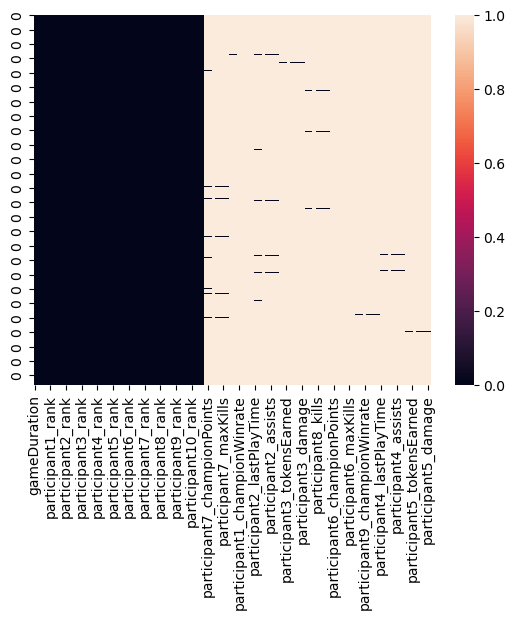

In [45]:
sns.heatmap(df.isna())

C:\Users\morit\AppData\Local\Temp\ipykernel_30600\1072140413.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

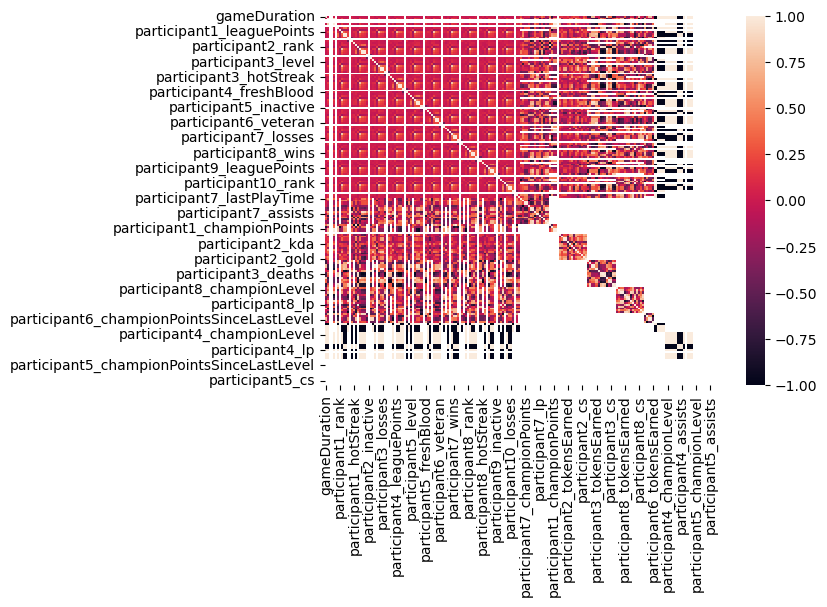

In [46]:
sns.heatmap(df.corr())